### USD/IRR Exchange Rate Forecasting (Using LSTM)

In [8]:
# Environment configuration
import os
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

# Standard library
import random
from datetime import timedelta

# Numerical / data handling
import numpy as np
import pandas as pd

# Machine learning / deep learning
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# File handling
import json
import pickle

# Seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [9]:
# Configure dataset path and load data
cwd = os.getcwd()
parent = os.path.dirname(cwd)
parent = os.path.dirname(parent)
dataset_path = os.path.join(parent, 'backend', 'data', 'Dollar_Rial_Price_Dataset.csv')

if os.path.exists(dataset_path):
    df = pd.read_csv(dataset_path)
    print("Successfully loaded dataset")
else:
    print("Dataset not found at the specified path.")

Successfully loaded dataset


In [10]:
# Inspect data 
print("=== Raw head ===")
print(df.head())
print("\n=== Info ===")
print(df.info())
print("\n=== NA counts ===")
print(df.isna().sum())
print("\n=== Columns ===")
print(df.columns.tolist())

=== Raw head ===
   Open Price  Low Price  High Price  Close Price Change Amount  \
0     1125400    1124800     1136200      1125300           800   
1     1102100    1101800     1128200      1126100         27700   
2     1076400    1076300     1098700      1098400         21700   
3     1078500    1075800     1078700      1076700          1900   
4     1077450    1077300     1079700      1078600           550   

  Change Percent Gregorian Date Persian Date  
0          0.07%     2025/11/13   1404/08/22  
1          2.52%     2025/11/12   1404/08/21  
2          2.02%     2025/11/11   1404/08/20  
3          0.18%     2025/11/10   1404/08/19  
4          0.05%     2025/11/09   1404/08/18  

=== Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3706 entries, 0 to 3705
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Open Price      3706 non-null   int64 
 1   Low Price       3706 non-null   int64 
 2

In [11]:
# Date handling and ordering (no resample/no forward fill) - Time series
df["Gregorian Date"] = pd.to_datetime(df["Gregorian Date"])
df = df.sort_values("Gregorian Date")
df = df.set_index("Gregorian Date")

print("\n=== Sorted head ===")
print(df.head())
print("\n=== Sorted tail ===")
print(df.tail())

# Inspect time gaps – keep them, do not fill them
print("\n=== Date differences (top counts) ===")
print(df.index.to_series().diff().value_counts().head(10))


=== Sorted head ===
                Open Price  Low Price  High Price  Close Price Change Amount  \
Gregorian Date                                                                 
2011-11-26           13700      13700       13700        13700           260   
2011-11-27           13440      13440       13440        13440           260   
2011-11-28           13495      13227       13667        13350             -   
2011-11-30           13580      13510       13830        13590            90   
2011-12-03           13638      13504       13833        13623            13   

               Change Percent Persian Date  
Gregorian Date                              
2011-11-26              1.93%   1390/09/05  
2011-11-27              1.93%   1390/09/06  
2011-11-28                  -   1390/09/07  
2011-11-30              0.67%   1390/09/09  
2011-12-03               0.1%   1390/09/12  

=== Sorted tail ===
                Open Price  Low Price  High Price  Close Price Change Amount  \
Gr

In [12]:
# Extract target and apply log transform
close_prices = df["Close Price"].astype(float)
log_prices = np.log(close_prices)

print("\n=== Log prices head ===")
print(log_prices.head())
print("\n=== Log prices tail ===")
print(log_prices.tail())


=== Log prices head ===
Gregorian Date
2011-11-26    9.525151
2011-11-27    9.505991
2011-11-28    9.499272
2011-11-30    9.517090
2011-12-03    9.519515
Name: Close Price, dtype: float64

=== Log prices tail ===
Gregorian Date
2025-11-09    13.891174
2025-11-10    13.889411
2025-11-11    13.909365
2025-11-12    13.934271
2025-11-13    13.933560
Name: Close Price, dtype: float64


In [13]:
# Create sequences for LSTM (univariate) - Scaling will be applied after splitting to avoid leakage
def create_sequences_1d(series_values, lookback, horizon):
    """
    series_values: 1D numpy array of log prices
    lookback: how many past steps to feed into the model
    horizon: forecast horizon in steps (we'll use 1)
    """
    X, y = [], []
    for i in range(len(series_values) - lookback - horizon + 1):
        X.append(series_values[i : i + lookback])
        y.append(series_values[i + lookback + horizon - 1])
    X = np.array(X) # (n_samples, lookback)
    y = np.array(y) # (n_samples,)
    return X, y

lookback = 90 # lookback window
horizon = 1 # forecast horizon

X_log, y_log = create_sequences_1d(log_prices.values, lookback, horizon)

# Reshape X to (samples, timesteps, features=1)
X_log = X_log.reshape(X_log.shape[0], X_log.shape[1], 1)
y_log = y_log.reshape(-1, 1)

print("\n=== Sequence shapes (log-space, unscaled) ===")
print("X_log:", X_log.shape, "y_log:", y_log.shape)


=== Sequence shapes (log-space, unscaled) ===
X_log: (3616, 90, 1) y_log: (3616, 1)


In [14]:
# Train / Val / Test split (time-ordered)
n_samples = X_log.shape[0]
train_size = int(n_samples * 0.8)
val_size = int(n_samples * 0.1)
test_size = n_samples - train_size - val_size

X_train_log = X_log[:train_size]
y_train_log = y_log[:train_size]

X_val_log = X_log[train_size : train_size + val_size]
y_val_log = y_log[train_size : train_size + val_size]

X_test_log = X_log[train_size + val_size :]
y_test_log = y_log[train_size + val_size :]

print("\n=== Split shapes (log-space) ===")
print("Train:", X_train_log.shape, y_train_log.shape)
print("Val:  ", X_val_log.shape, y_val_log.shape)
print("Test: ", X_test_log.shape, y_test_log.shape)


=== Split shapes (log-space) ===
Train: (2892, 90, 1) (2892, 1)
Val:   (361, 90, 1) (361, 1)
Test:  (363, 90, 1) (363, 1)


In [15]:
# Scaling - scaler will only be fit on training data to avoid leakage
scaler = MinMaxScaler()

# Fit scaler on training log values (both X and y) flattened together
train_log_flat = np.concatenate(
    [
        X_train_log.reshape(-1, 1),
        y_train_log.reshape(-1, 1),
    ],
    axis=0,
)
scaler.fit(train_log_flat)

def scale_X_y(X_log, y_log, scaler):
    # X_log: (samples, lookback, 1), y_log: (samples, 1)
    X_scaled = scaler.transform(X_log.reshape(-1, 1)).reshape(X_log.shape)
    y_scaled = scaler.transform(y_log)
    return X_scaled, y_scaled

X_train, y_train = scale_X_y(X_train_log, y_train_log, scaler)
X_val, y_val = scale_X_y(X_val_log, y_val_log, scaler)
X_test, y_test = scale_X_y(X_test_log, y_test_log, scaler)

print("\n=== After scaling (shapes) ===")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:  ", X_val.shape, "y_val:", y_val.shape)
print("X_test: ", X_test.shape, "y_test:", y_test.shape)


=== After scaling (shapes) ===
X_train: (2892, 90, 1) y_train: (2892, 1)
X_val:   (361, 90, 1) y_val: (361, 1)
X_test:  (363, 90, 1) y_test: (363, 1)


In [16]:
# Build and train the LSTM model
model = Sequential(
    [
        LSTM(64, activation="tanh", return_sequences=False, input_shape=(lookback, 1)),
        Dropout(0.3),
        Dense(1),
    ]
)

model.compile(optimizer="adam", loss="mse")

es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
mc = ModelCheckpoint(
    "best_lstm_model.keras", monitor="val_loss", save_best_only=True
)

print("\n=== Starting training ===")
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[es, mc],
    verbose=1,
)

print("\n=== Training complete ===")
print("Best validation loss:", min(history.history["val_loss"]))


=== Starting training ===
Epoch 1/100


c:\Users\Suhand\.conda\envs\ts-windows\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0231 - val_loss: 2.9448e-05
Epoch 2/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0031 - val_loss: 7.5691e-05
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0028 - val_loss: 0.0013
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0025 - val_loss: 1.7357e-04
Epoch 5/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0023 - val_loss: 2.0599e-04
Epoch 6/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0023 - val_loss: 0.0010
Epoch 7/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0023 - val_loss: 2.7731e-05
Epoch 8/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 9/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0019 - val_loss: 3.2413e-05
Epoch 10/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0019 - val_loss: 5.2771e-04
Epoch 11/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0018 - val_loss: 9.5523e-05
Epoch 12/100
91/91 ━━━━━━━━━━━━━

In [17]:
# Load best model and evaluate on test set
best_model = load_model("best_lstm_model.keras", compile=False)

print("\n=== Making predictions on test set ===")
y_pred_scaled = best_model.predict(X_test)

# Inverse scale back to log-space
y_pred_log = scaler.inverse_transform(y_pred_scaled)
y_true_log = scaler.inverse_transform(y_test)

# Back-transform log to actual prices
y_pred = np.exp(y_pred_log).reshape(-1)
y_true = np.exp(y_true_log).reshape(-1)


=== Making predictions on test set ===
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [18]:
# Metrics and residuals
rmse = np.sqrt(mean_squared_error(y_true, y_pred)) # Root Mean Squared Error
mae = mean_absolute_error(y_true, y_pred) # Mean Absolute Error
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100 # Mean Absolute Percentage Error

print("\n=== Test metrics (price space) ===")
print(f"RMSE: {rmse:,.2f} IRR")
print(f"MAE:  {mae:,.2f} IRR")
print(f"MAPE: {mape:.3f}%")

residuals = y_true - y_pred
res_mean = np.mean(residuals)
res_std = np.std(residuals)

print("\n=== Residual summary ===")
print(f"Mean residual: {res_mean:,.4f} IRR")
print(f"Residual std:  {res_std:,.4f} IRR")

# print a small sample of residuals
print("\n=== First 10 residuals (Actual - Predicted) ===")
print(residuals[:10])


=== Test metrics (price space) ===
RMSE: 33,043.13 IRR
MAE:  23,312.12 IRR
MAPE: 2.632%

=== Residual summary ===
Mean residual: 13,783.3383 IRR
Residual std:  30,031.1181 IRR

=== First 10 residuals (Actual - Predicted) ===
[ 26559.75    15469.3125  16971.4375   8938.125    7673.        177.6875
 -14655.     -18893.6875 -11935.6875 -15302.25  ]


In [19]:
# Forecast next day's close price + confidence intervals
# We use the last 'lookback' trading days (irregular dates, no fake (generated/ffilled) days)
last_window = close_prices.values[-lookback:]
last_window_log = np.log(last_window)

# Scale with training-fitted scaler
last_window_scaled = scaler.transform(last_window_log.reshape(-1, 1))
X_last = last_window_scaled.reshape(1, lookback, 1)

print("\n=== Forecasting next day ===")
y_next_scaled = best_model.predict(X_last)
y_next_log = scaler.inverse_transform(y_next_scaled)
y_next = float(np.exp(y_next_log)[0, 0])  # raw model forecast in price space

# Bias-adjusted forecast using residual mean
forecast_center = y_next + res_mean

# Confidence intervals using residual std (assuming approx normal errors)
ci_68 = (forecast_center - res_std, forecast_center + res_std)
ci_95 = (forecast_center - 1.96 * res_std, forecast_center + 1.96 * res_std)

last_date = df.index[-1]
tomorrow = last_date + timedelta(days=1)

print("\n=== Final forecast ===")
print(f"Tomorrow's date (next calendar day): {tomorrow.date()}")
print(f"Forecasted close price (IRR): {forecast_center:,.0f}")
print(f"68% confidence interval: {ci_68[0]:,.0f} – {ci_68[1]:,.0f}")
print(f"95% confidence interval: {ci_95[0]:,.0f} – {ci_95[1]:,.0f}")


=== Forecasting next day ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

=== Final forecast ===
Tomorrow's date (next calendar day): 2025-11-14
Forecasted close price (IRR): 1,085,815
68% confidence interval: 1,055,784 – 1,115,846
95% confidence interval: 1,026,954 – 1,144,676


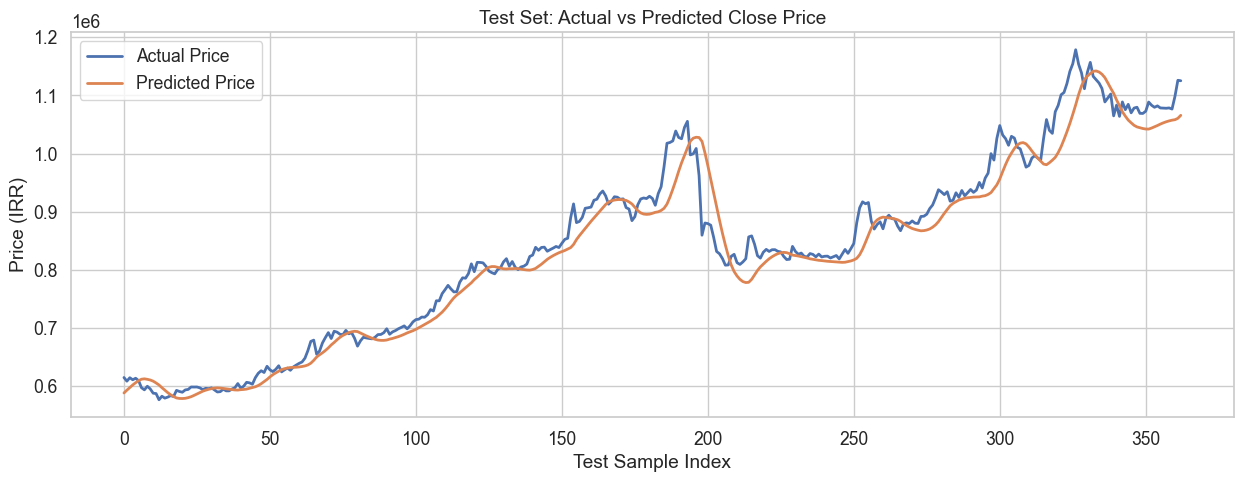

In [20]:
# Visualization of the metrics above
sns.set_theme(style="whitegrid", font_scale=1.15)

# Test: Actual vs Predicted
plt.figure(figsize=(15, 5))
plt.plot(y_true, label="Actual Price", linewidth=2)
plt.plot(y_pred, label="Predicted Price", linewidth=2)
plt.title("Test Set: Actual vs Predicted Close Price")
plt.xlabel("Test Sample Index")
plt.ylabel("Price (IRR)")
plt.legend()
plt.show()

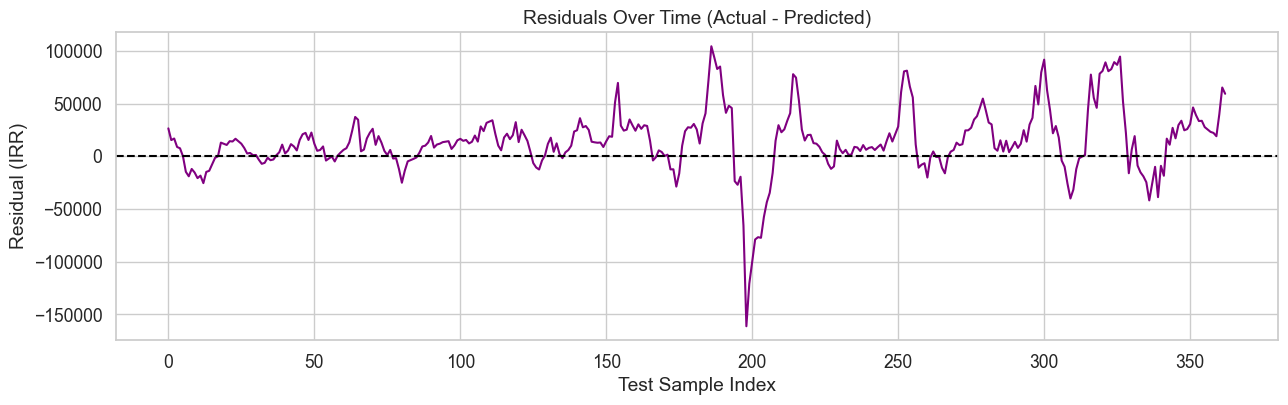

In [21]:
# Residuals over time (error sequence)
plt.figure(figsize=(15, 4))
plt.plot(residuals, color="purple")
plt.axhline(0, color='black', linestyle='--')
plt.title("Residuals Over Time (Actual - Predicted)")
plt.xlabel("Test Sample Index")
plt.ylabel("Residual (IRR)")
plt.show()

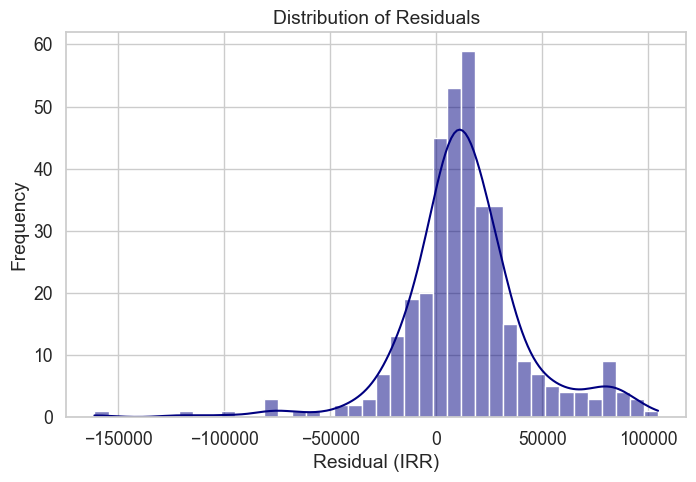

In [22]:
# Residual Distribution
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=40, color="navy")
plt.title("Distribution of Residuals")
plt.xlabel("Residual (IRR)")
plt.ylabel("Frequency")
plt.show()

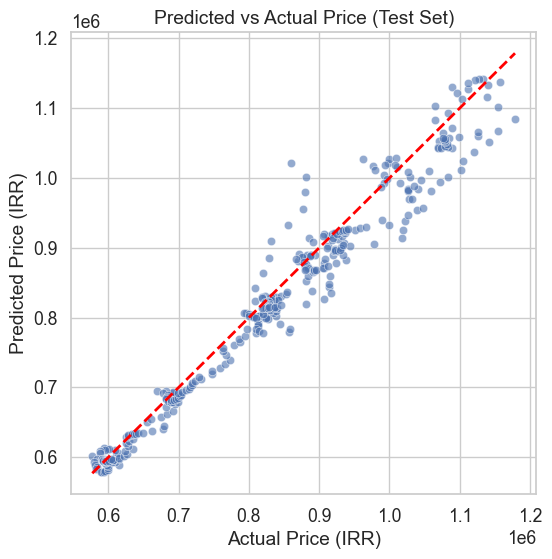

In [23]:
# Scatter Plot: Predicted vs Actual Price
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
plt.plot([min(y_true), max(y_true)],
         [min(y_true), max(y_true)],
         color='red', linestyle='--', linewidth=2)
plt.title("Predicted vs Actual Price (Test Set)")
plt.xlabel("Actual Price (IRR)")
plt.ylabel("Predicted Price (IRR)")
plt.show()

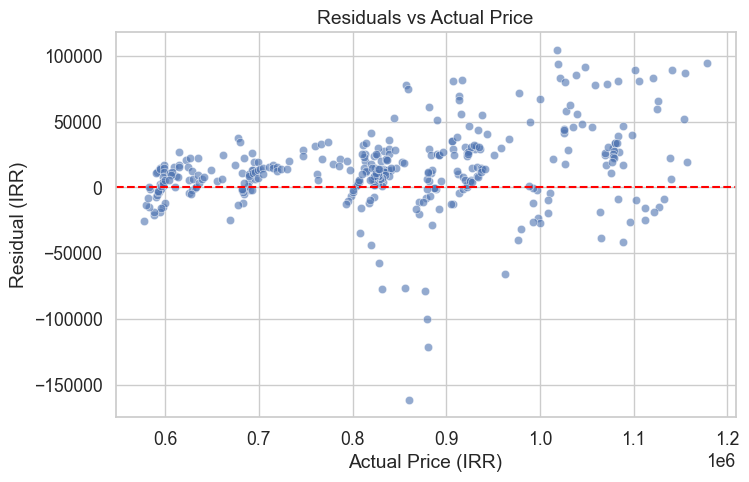

In [24]:
# Residuals vs Actual Price
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_true, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Actual Price")
plt.xlabel("Actual Price (IRR)")
plt.ylabel("Residual (IRR)")
plt.show()

In [25]:
# Save the important results into a dict
results = {
    "test_metrics": {
        "RMSE": float(rmse),
        "MAE": float(mae),
        "MAPE_percent": float(mape)
    },
    "residual_summary": {
        "mean_residual": float(res_mean),
        "residual_std": float(res_std)
    }
}

# Save as JSON next to the notebook/script
output_path = os.path.join(os.getcwd(), "lstm_results.json")

with open(output_path, "w") as f:
    json.dump(results, f, indent=4)

print("\n=== Saved results to:", output_path, "===")


=== Saved results to: c:\Users\Suhand\Desktop\usd_irr\notebooks\ipynb\lstm_results.json ===


In [26]:
# Save scaler for future use
scaler_path = os.path.join(os.getcwd(), "lstm_scaler.pkl")

with open(scaler_path, "wb") as f:
    pickle.dump(scaler, f)

print("\n=== Scaler saved to:", scaler_path, "===")


=== Scaler saved to: c:\Users\Suhand\Desktop\usd_irr\notebooks\ipynb\lstm_scaler.pkl ===
